In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [3]:
paths = []
labels = []
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/audio-emotion/tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [4]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/audio-emotion/tess/YAF_...,fear
1,/content/drive/MyDrive/audio-emotion/tess/YAF_...,fear
2,/content/drive/MyDrive/audio-emotion/tess/YAF_...,fear
3,/content/drive/MyDrive/audio-emotion/tess/YAF_...,fear
4,/content/drive/MyDrive/audio-emotion/tess/YAF_...,fear


In [5]:
df['label'].value_counts()

,count
label,
fear,800
sad,800
disgust,800
neutral,800
ps,800
angry,800
happy,800


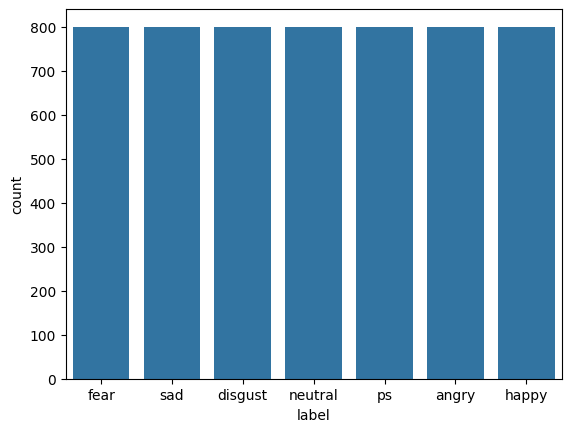

In [6]:
sns.countplot(x = df['label'])
plt.show()

In [7]:
# Assuming your DataFrame df is already created with paths and labels
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

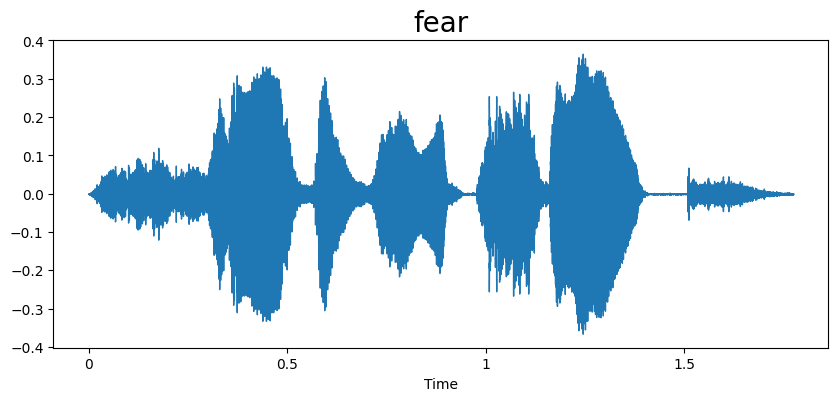

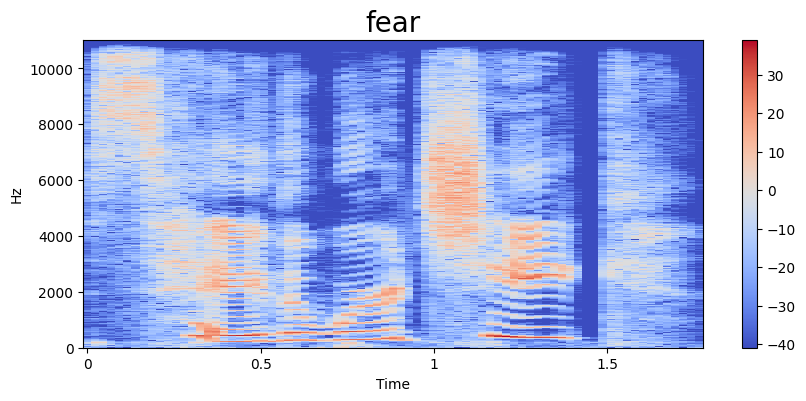

In [8]:
emotion = 'fear'
path = df['speech'][df['label'] == emotion][0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

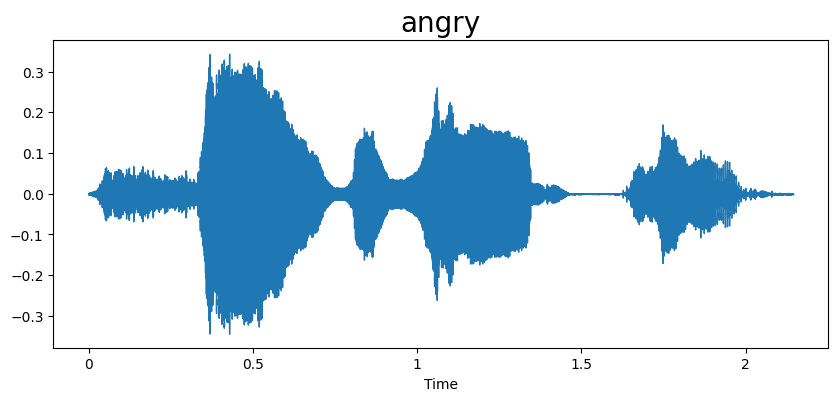

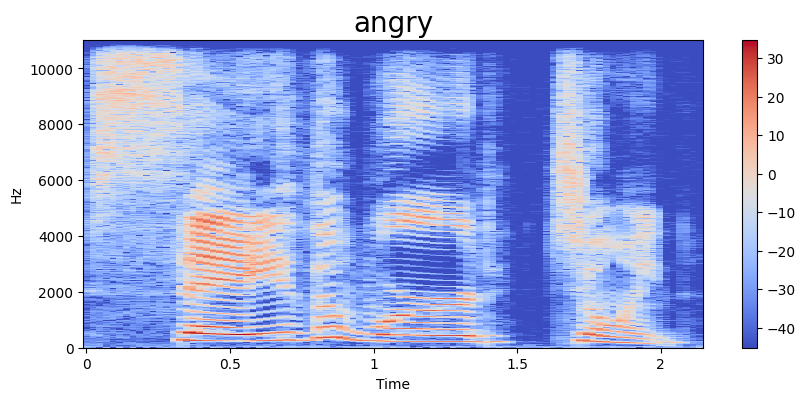

In [9]:
emotion = 'angry'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

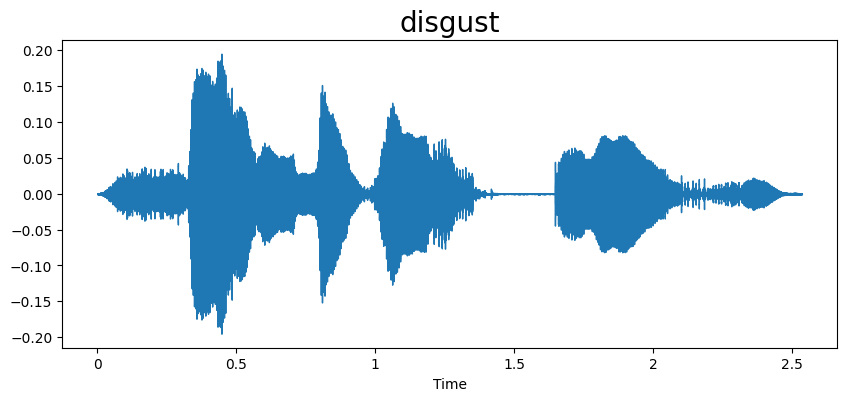

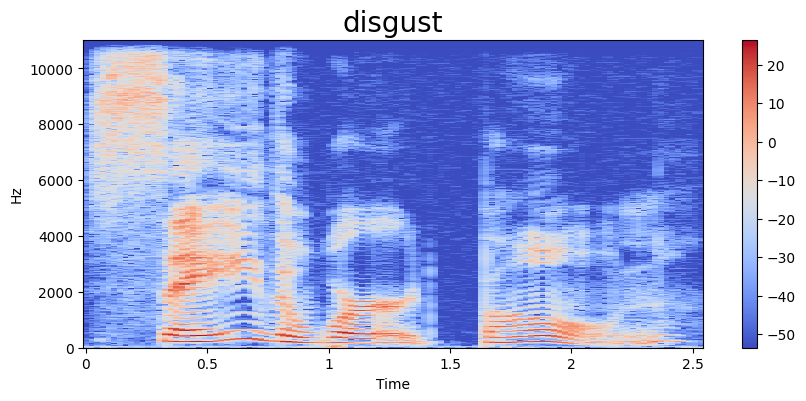

In [10]:
emotion = 'disgust'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

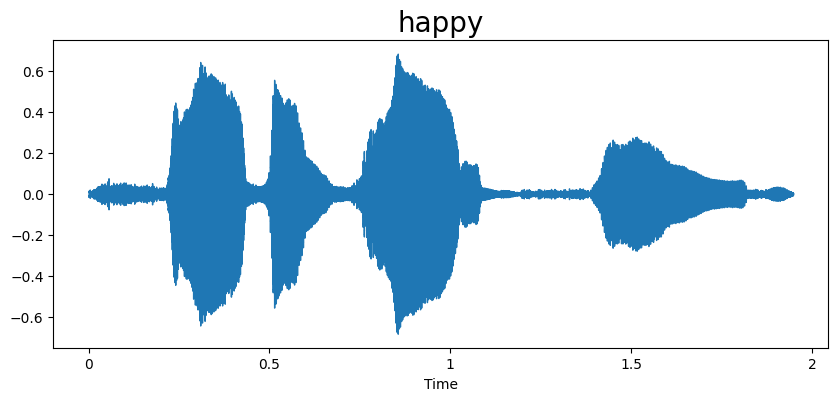

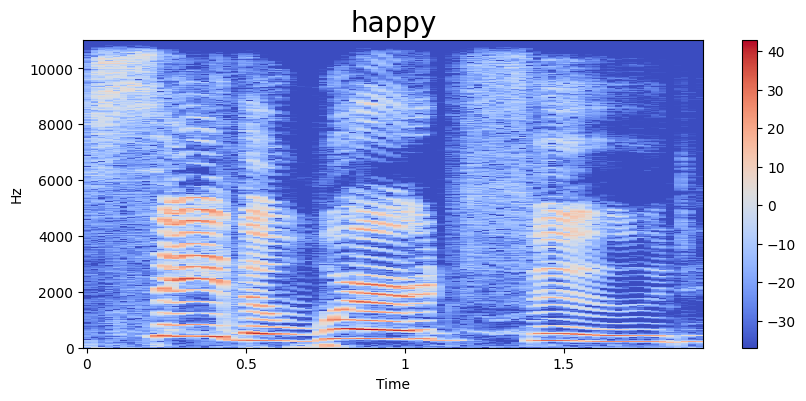

In [11]:
emotion = 'happy'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

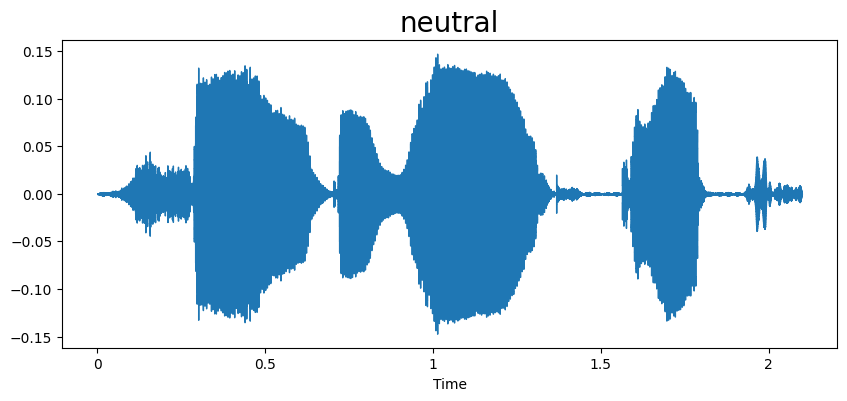

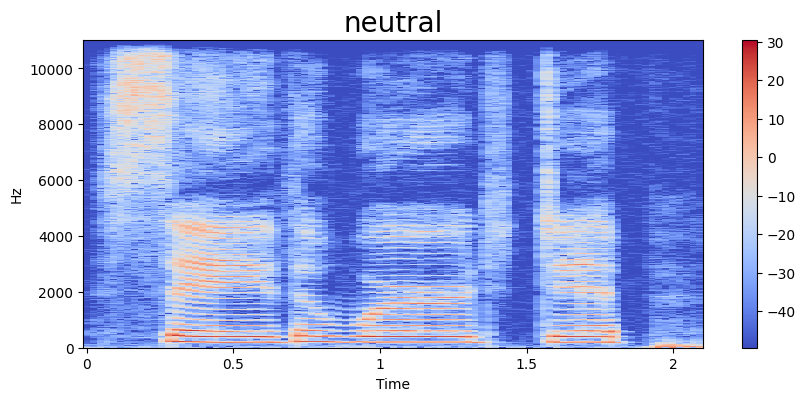

In [12]:
emotion = 'neutral'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

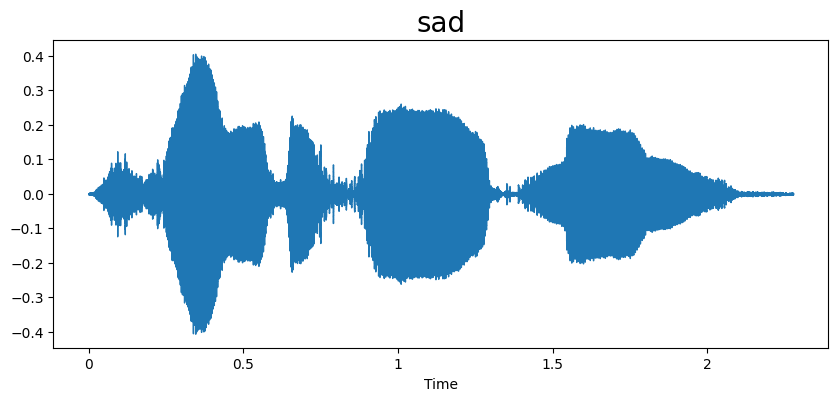

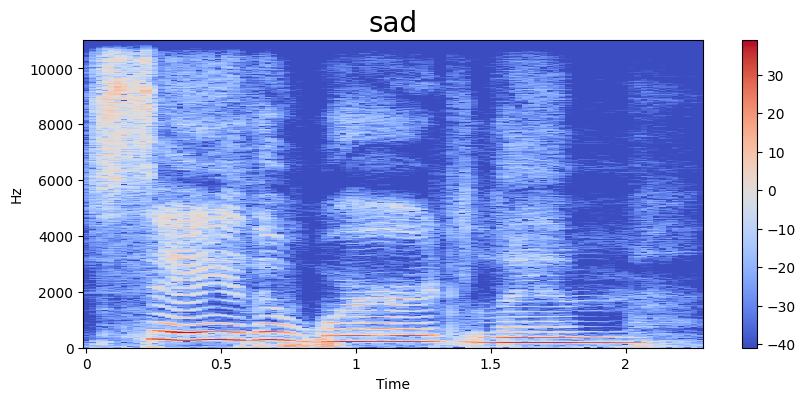

In [14]:
emotion = 'sad'
path = np.array(df['speech'][df['label'] == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

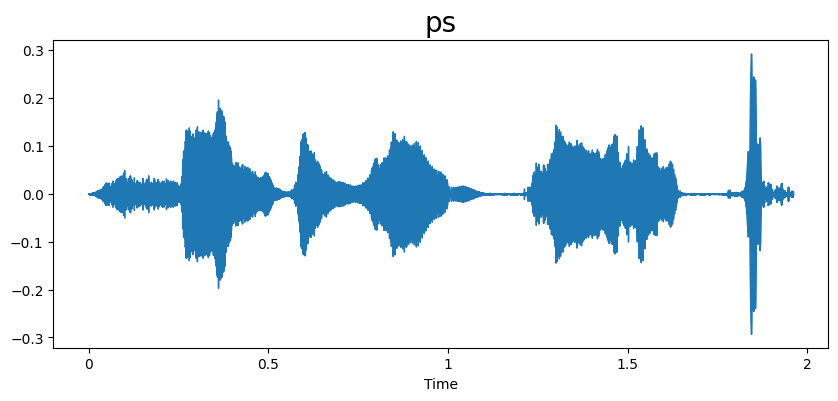

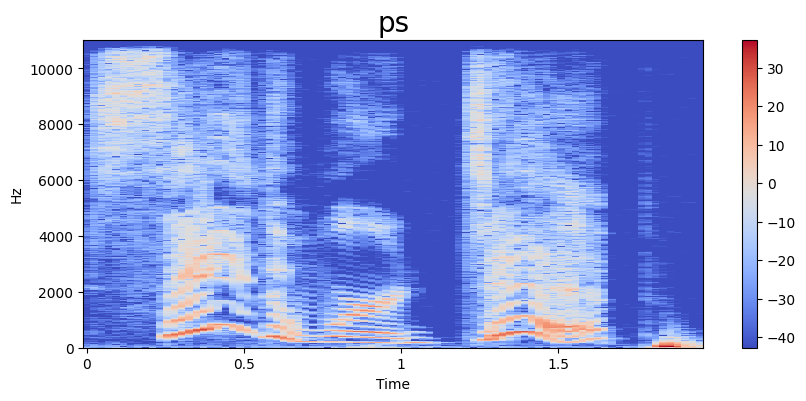

In [13]:
emotion = 'ps'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
def extract_mfcc(filename, max_pad_len=100):
    y, sr = librosa.load(filename, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

In [16]:
# Extract MFCCs for each audio file
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
x = np.array([x for x in x_mfcc])
x = np.expand_dims(x, -1)  # Expanding dimensions for LSTM input

In [17]:
# One-Hot Encode labels
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']]).toarray()

In [18]:
print(y[:5])  # Prints the first 5 elements of the array


[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 40)).reshape(x.shape)

In [20]:
print(np.isnan(x).any(), np.isinf(x).any())


False False


In [21]:
# Reshape input data
x = x.squeeze(-1)  # Remove the last dimension

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=labels)

In [23]:
# Define the model with the correct input shape
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False, input_shape=(40, 100))),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

In [24]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Audio_sentimentAnalysis_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [26]:
# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.1403 - loss: 2.0895 - val_accuracy: 0.3471 - val_loss: 1.7778 - learning_rate: 1.0000e-04
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.2716 - loss: 1.8166 - val_accuracy: 0.4855 - val_loss: 1.6119 - learning_rate: 1.0000e-04
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.3552 - loss: 1.6566 - val_accuracy: 0.5926 - val_loss: 1.4456 - learning_rate: 1.0000e-04
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.4321 - loss: 1.5298 - val_accuracy: 0.6685 - val_loss: 1.2849 - learning_rate: 1.0000e-04
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.5160 - loss: 1.3592 - val_accuracy: 0.7388 - val_loss: 1.1137 - learning_rate: 1.0000e-04
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.5562 - loss: 1.2537 - val_accuracy: 0.7779 - val_loss: 0.9698 - learning_rate: 1.0000e-04
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step

In [27]:
# Function to plot training and validation metrics
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

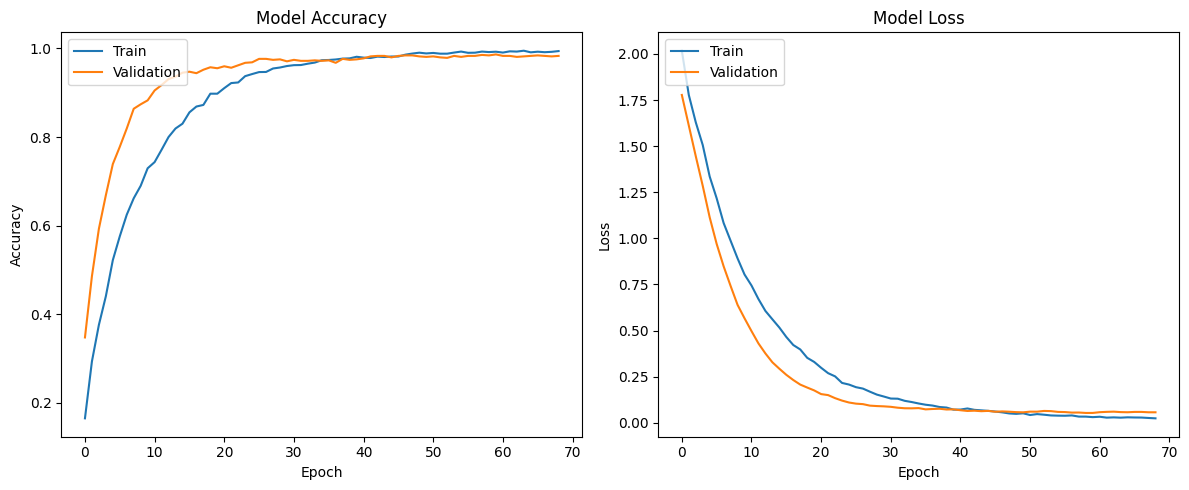

In [28]:
plot_metrics(history)

In [29]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/Audio_SentimentAnalysis_model.h5')

In [30]:

# Load the model
loaded_model = load_model('/content/drive/MyDrive/Audio_SentimentAnalysis_model.h5')


In [31]:
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9814 - loss: 0.0549
Test Loss: 0.04725324362516403
Test Accuracy: 0.9857142567634583


In [32]:
y_pred = loaded_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


In [33]:
y_pred_classes = y_pred.argmax(axis=-1)

In [36]:
import numpy as np

# Convert y_test from one-hot encoding to class labels if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=-1)
else:
    y_test_labels = y_test  # already in label format

# Generate a classification report
print(classification_report(y_test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.99      0.99      0.99       160
           2       1.00      0.97      0.99       160
           3       0.97      0.97      0.97       160
           4       0.99      1.00      0.99       160
           5       0.96      0.99      0.98       160
           6       0.99      0.99      0.99       160

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



[[158   0   0   1   0   1   0]
 [  0 158   0   0   2   0   0]
 [  0   0 156   4   0   0   0]
 [  0   0   0 155   0   5   0]
 [  0   0   0   0 160   0   0]
 [  1   0   0   0   0 158   1]
 [  0   1   0   0   0   0 159]]


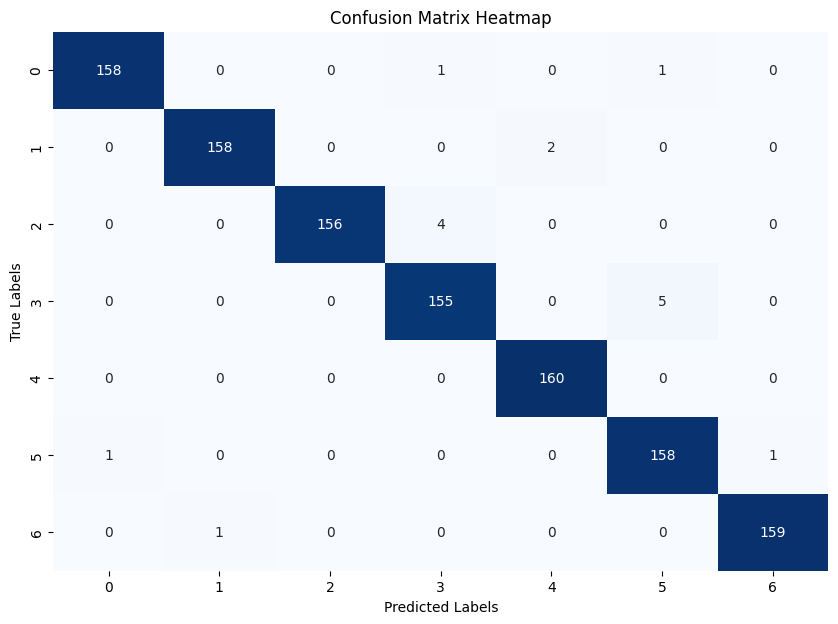

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)
print(conf_matrix)
# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()